In [1]:
using LinearAlgebra
using Unitful
using UnitfulAstro
using OrdinaryDiffEq
using Plots
using FLoops
using Distributed
#include("./GalaxyCollisionFunctions.jl")
addprocs(4)
theme(:dracula)

In [2]:
const G = 4.3009E-3 *1u"pc *(km/s)^2 /Msun"
function format_parameters(galaxy_args)
    #I didn't have this at first, but this makes all galaxies have an uniform format. Not too crazy
    return Dict(
        "mass" => galaxy_args[1]*1u"Msun",
        "radius"     => galaxy_args[2]*1u"pc",
        "center_pos" => galaxy_args[3].*1u"kpc",
        "center_vel" => galaxy_args[4].*1u"km/s",
        "normal"     => galaxy_args[5],
        "Nᵣ"    => galaxy_args[6],
        "Nₛ"    => galaxy_args[7],
        "softening"  => galaxy_args[8]
    )
end
function init_disk!(galaxy,dT=1E-4u"yr")
    #=
    This function takes a 'galaxy' as an argument, which is an array of 8 arguments=>
        [mass,radius,center_pos,center_vel,normal,N_rings,N_stars,softening]
    And outputs the star positions, velocities and the velocity scale.
    =#
    dr = (1-galaxy["softening"]) * galaxy["radius"]/galaxy["Nᵣ"] # Disregarding the softening, this is just the width of the rings(raidus/number of slices)
    StarsPerRing = trunc(Int64,galaxy["Nₛ"]/galaxy["Nᵣ"])
#-------------------------------------------------------------Rotations--------------------------------------------------------------
    if norm(galaxy["normal"]) == 0 
        Rotation = I
    else 
        cosθ = normalize(galaxy["normal"])[3]
        sinθ = √(1-cosθ^2)
        u = [0,0,1] × normalize(galaxy["normal"])
        if norm(u) == 0 
            Rotation = I
        else 
         u = normalize(u)

        @show Rotation = [
            u[1]*u[1]*(1-cosθ)+cosθ u[1]*u[2]*(1-cosθ)-u[2]*sinθ u[1]*u[3]*(1-cosθ)+u[1]*sinθ;

            u[2]*u[1]*(1-cosθ)+u[3]*sinθ u[2]*u[2]*(1-cosθ)+cosθ u[2]*u[3]*(1-cosθ)-u[1]*sinθ;

            u[3]*u[1]*(1-cosθ)+u[2]*sinθ u[3]*u[1]*(1-cosθ)+u[1]*sinθ u[3]*u[3]*(1-cosθ)+cosθ
            ]
        end
    end
#-----------------------------------------------------------------------------------------------------------------------------------
    galaxy["star_pos"] = []
    galaxy["star_vel"] = []

    R = galaxy["softening"] * galaxy["radius"]
    for i ∈ 1:galaxy["Nᵣ"] #iterate over the rings
        #Randomly distribute the initial radii and angles 
        rₛ =(R * ones(StarsPerRing) + dr *rand(StarsPerRing))./1u"pc" #creates an n-dimensional vector of radii from R to R+dr 
        ϕₛ = 2π *rand(StarsPerRing)

        # Positions 
        vecᵣ = (Rotation * ([rₛ.*cos.(ϕₛ),rₛ.*sin.(ϕₛ),zeros(StarsPerRing)])).*1u"pc"
        x = ustrip.(u"m",galaxy["center_pos"][1].+vecᵣ[1])#here, we strip our units into our 'integrating' unitlessness because units don't really play nice in arrays of arrays
        y = ustrip.(u"m",galaxy["center_pos"][2].+vecᵣ[2])
        z = ustrip.(u"m",galaxy["center_pos"][3].+vecᵣ[3])

        # Velocities
        Tₛ = 2π * uconvert.(u"s",sqrt.((rₛ*1u"pc").^3/(G *Introoder["mass"])))

        Δϕ = 2π *uconvert(u"s",dT)./Tₛ 

        vecᵥ = (Rotation* [(rₛ/(uconvert(u"s",dT)*1u"1/s")).*(cos.(ϕₛ)-cos.(ϕₛ-Δϕ)),rₛ/(uconvert(u"s",dT)*1u"1/s").*(sin.(ϕₛ)-sin.(ϕₛ-Δϕ)),zeros(StarsPerRing)])*1u"pc/s"
        v₁ = ustrip.(u"m/s",galaxy["center_vel"][1].+vecᵥ[1])
        v₂ = ustrip.(u"m/s",galaxy["center_vel"][2].+vecᵥ[2])
        v₃ = ustrip.(u"m/s",galaxy["center_vel"][3].+vecᵥ[3])
        for j ∈ 1:StarsPerRing
            push!(galaxy["star_pos"],[x[j],y[j],z[j]])
            push!(galaxy["star_vel"],[v₁[j],v₂[j],v₃[j]])
        end
        R += dr
    end 
    galaxy["vel_scale"]=uconvert(u"km/s",√(G*galaxy["mass"]/(0.5*R)))
end


function evolve_disk(galaxy,dT=1e-4u"yr",N_steps=100000,frames=500)
    divs = trunc(Int64,N_steps/frames)
    #Integration stuff
    dT=ustrip(u"s",dT)
    rₘ=ustrip(u"m",galaxy["softening"]*galaxy["radius"])
    Nₛ=galaxy["Nₛ"]
    
    #Galaxy stuff
    M = ustrip(u"Msun",galaxy["mass"])
    R₀ = ustrip.(u"m",galaxy["center_pos"])
    V₀ = ustrip.(u"m/s",galaxy["center_vel"])

    #star stuff
    rₛ=galaxy["star_pos"]
    vₛ=galaxy["star_vel"]

    function Gravity(dq,q,p,t) 
        r = q[1:3]
        R = q[4:6]
        ddr = ustrip(u"m^3/s^2",G*M*1u"Msun")*(R-r)/max(norm(R-r),rₘ)^3
        ddR = [0,0,0]
        append!(ddr,ddR)
        return ddr
    end
    Trolleg=[]
    Integrator=[]
    for i ∈ 1:Nₛ
        append!(vₛ[i],V₀)
        append!(rₛ[i],R₀)
    end
    for i ∈ 1:Nₛ
        push!(Trolleg,SecondOrderODEProblem(Gravity,vₛ[i],rₛ[i],(0,dT*N_steps)))
        push!(Integrator,init(Trolleg[i],dt=dT,McAte2()))
    end 
    snapshot = zeros(frames,Nₛ+1,3)
    time = zeros(frames)
        for i ∈ 1:frames
            for j ∈ 1:Nₛ
                snapshot[i,j,:] =Integrator[j].u[7:9]*3.240779289444365e-20
            end
            snapshot[i,Nₛ+1,:] = Integrator[1].u[10:12]*3.240779289444365e-20
            time[i]=Integrator[1].t

            for j ∈ 1:divs
                step!.(Integrator)
            end
        end
    return snapshot,time 
end

function gif_galaxy(data,time,xlimit=[0,0],ylimit=[0,0],zlimit=[0,0])
    if ((norm(xlimit) == 0.0) || (norm(ylimit) == 0.0) || (norm(zlimit) == 0.0))
        xlimit = [minimum(data[:,:,1]),maximum(data[:,:,1])]
        ylimit = [minimum(data[:,:,2]),maximum(data[:,:,2])]
        zlimit = [minimum(data[:,:,3]),maximum(data[:,:,3])]
    end
    @gif for i ∈ 1:length(time)
        scatter3d(xlim=xlimit,ylim=ylimit,zlim=zlimit)
        for j ∈ 1:Introoder["Nₛ"]
            scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=0.5)
           # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
        end
        scatter3d!(data[i:i,Introoder["Nₛ"]+1,1],data[i:i,Introoder["Nₛ"]+1,2],data[i:i,Introoder["Nₛ"]+1,3], color=:black,legends=false)
    end 
end

gif_galaxy (generic function with 4 methods)

In [3]:
#Introoder = format_parameters([5e10, 10, [-5,5,1], [15,-15,0], [1,-1,2^0.5], 10, 400, 0.025])
Introoder = format_parameters([1e10,5,[25,-25,-5],[-75,75,0],[0,0,1],5,1000,0.025])
init_disk!(Introoder)
Introoder["star_vel"]
data, time = evolve_disk(Introoder,1u"yr",10000,400)

([24.99957913699223 25.000460670468314 … 25.002682101271137 25.0; 24.99975501904903 25.00030456265845 … 25.002616875012574 24.999998082414642; … ; 24.99938384277761 24.998767769591062 … 24.995917227838316 24.999236801028424; 24.99957950829388 24.998919438732806 … 24.995866699766445 24.99923488344307;;; -25.000396151352696 -24.999103677850385 … -24.996843991495464 -25.0; -25.00052247060311 -24.99903804035385 … -24.99678934710831 -24.999998082414642; … ; -24.999795771676826 -25.00012878557769 … -24.99676000993605 -24.999236801028424; -24.999698896760336 -25.00019202572611 … -24.99682461394869 -24.99923488344307;;; -4.999999999999999 -4.999999999999999 … -4.999999999999999 -4.999999999999999; -4.999999999999999 -4.999999999999999 … -4.999999999999999 -4.999999999999999; … ; -4.999999999999999 -4.999999999999999 … -4.999999999999999 -4.999999999999999; -4.999999999999999 -4.999999999999999 … -4.999999999999999 -4.999999999999999], [0.0, 7.8894e8, 1.57788e9, 2.36682e9, 3.15576e9, 3.9447e9, 

[ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\GalaxyCollision\tmp.gif


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\GalaxyCollision\\tmp.gif")
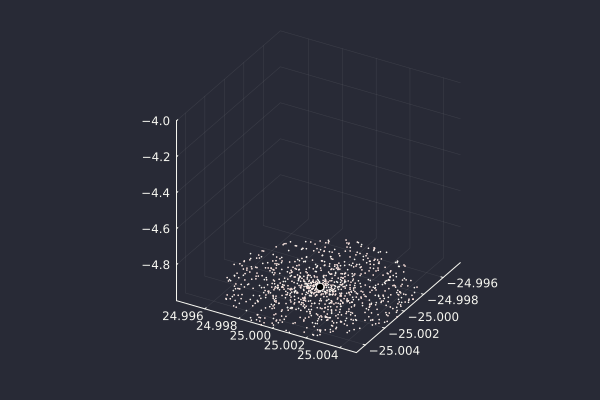

In [4]:
xlimits = [minimum(data[:,:,1]),maximum(data[:,:,1])]
ylimits = [minimum(data[:,:,2]),maximum(data[:,:,2])]
zlimits = [minimum(data[:,:,3]),maximum(data[:,:,3])]
@gif for i ∈ 1:length(time)
    scatter3d(xlim=xlimits,ylim=ylimits,zlim=zlimits)
    for j ∈ 1:Introoder["Nₛ"]
        scatter3d!(data[i:i,j,1],data[i:i,j,2],data[i:i,j,3], color=:red,legends=false,markersize=0.5)
       # i > trail ? plot3d!(Rotated[j][1,1:i],Rotated[j][2,1:i],Rotated[j][3,1:i]) : nothing
    end
    scatter3d!(data[i:i,Introoder["Nₛ"]+1,1],data[i:i,Introoder["Nₛ"]+1,2],data[i:i,Introoder["Nₛ"]+1,3], color=:black,legends=false)
end


In [5]:
#gif_galaxy(data,time)

In [6]:
cosθ = normalize(Introoder["normal"])
Rotation = rand(3,3)
R = Introoder["softening"] * Introoder["radius"]
dr = (1-Introoder["softening"]) * Introoder["radius"]/Introoder["Nᵣ"] # Disregarding the softening, this is just the width of the rings(raidus/number of slices)
StarsPerRing = trunc(Int64,Introoder["Nₛ"]/Introoder["Nᵣ"])
rₛ = (R * ones(StarsPerRing) + dr *rand(StarsPerRing))./1u"pc" #creates an n-dimensional vector of radii from R to R+dr 
ϕₛ = 2π *rand(StarsPerRing)
cosθ = normalize(Introoder["normal"])[3]
        sinθ = √(1-cosθ^2)
        u = [0,0,1] × normalize(Introoder["normal"])
        u = normalize(u)

        Rotation = [
        u[1]*u[1]*(1-cosθ)+cosθ u[1]*u[2]*(1-cosθ)-u[2]*sinθ u[1]*u[3]*(1-cosθ)+u[1]*sinθ;

        u[2]*u[1]*(1-cosθ)+u[3]*sinθ u[2]*u[2]*(1-cosθ)+cosθ u[2]*u[3]*(1-cosθ)-u[1]*sinθ;

        u[3]*u[1]*(1-cosθ)+u[2]*sinθ u[3]*u[1]*(1-cosθ)+u[1]*sinθ u[3]*u[3]*(1-cosθ)+cosθ
        ]
        vecᵣ =Rotation.*[rₛ.*cos.(ϕₛ),rₛ.*sin.(ϕₛ),zeros(StarsPerRing)].*1u"pc"
        Introoder["center_pos"][1] .+ vecᵣ[1]
        #Tₛ = 2π *sqrt.(((rₛ*1u"pc")^3)/(G *galaxy["mass"]))
   uconvert.(u"s",sqrt.((rₛ*1u"pc").^3/(G *Introoder["mass"])))
   dT=1E-4u"yr"
uconvert(u"s",dT)
Introoder["center_pos"][1].+vecᵣ[1]


200-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
     ⋮
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m
 NaN m

In [7]:
uconvert(u"kpc",1u"m") 

3.240779289444365e-20 kpc